In [1]:
import os
os.chdir('../')
from helpers import *

mousenums:  ['230', '355', '358', '362', '673', '674', '816', '825']


In [2]:
mousenums = ['230', '355', '362', '673', '674', '816', '825']

In [3]:
# epm+rat
timeBefore = 40
timeAfter = 40

mousenums = ['230', '355', '362', '673', '674', '816', '825']
if 'ab' not in globals():
    ab = np.zeros((4, 7, 4)) # behav, mouse, ctype (all, open, neither, closed)

behavtraces = []
ctab = []
Nb = np.zeros(4)
for b, behavFrame in enumerate(['approachFrameMS', 'stretchFrameMS', 'escapeFrameMS', 'freezeFrameMS']):
    traces = []
    ctab.append([])
    for m, mouse in enumerate(mousenums):
        try:
            track1, neur1, behav1 = getdicts(foldnames, mouse, 'epm')
            track2, neur2, behav2 = getdicts(foldnames, mouse, 'rat1')
            rvel = track2['ratVelMS'].flatten()
            calc1, calc2 = getcalcs(foldnames, mouse, 'epm', 'rat1')
            calc2 = zscore(calc2)
            
            mpos2 = track2['mouse_positionMS']
            ref0 = np.min(mpos2[:, 0])
            ref70 = np.max(track2['rat_positionMS'][:, 0])
            mrdist = track2['distanceMouseRatMS'].flatten() / (ref70-ref0) * 70 # in cm
            mpos2[:, 0] = minmaxscale(mpos2[:, 0], 0, 70, np.max(track2['rat_positionMS'][:, 0]))
            mpos2[:, 1] = minmaxscale(mpos2[:, 1], 0, 26)
            
            speed = track2['mouseVelMS'].flatten()
            
            if behavFrame == 'freezeFrameMS' and behav2['escapeFrameMS'].size > 0:
                fstarts = behav2['freezeFrameMS'][:, 0].astype('int')
                eends = behav2['escapeFrameMS'][:, 1].astype('int')
                f_keeps = np.ones(len(fstarts), dtype='bool')
                for i in range(len(fstarts)):
                    dif = fstarts[i] - eends
                    if np.sum((dif >= 0)*(dif < 75)) > 0:
                        #print('hello')
                        f_keeps[i] = 0
                behav2['freezeFrameMS'] = behav2['freezeFrameMS'][f_keeps]
                print(mouse, 'f', np.size(f_keeps), np.sum(f_keeps==0), np.sum(f_keeps))
            
            if behavFrame == 'escapeFrameMS' and behav2['freezeFrameMS'].size > 0:
                estarts = behav2['escapeFrameMS'][:, 0].astype('int')
                fends = behav2['freezeFrameMS'][:, 1].astype('int')
                e_keeps = np.ones(len(estarts), dtype='bool')
                for i in range(len(estarts)):
                    dif = estarts[i] - fends
                    if np.sum((dif >=0)*(dif < 75)) > 0:
                        e_keeps[i] = 0
                behav2['escapeFrameMS'] = behav2['escapeFrameMS'][e_keeps]
                print(mouse, 'e', np.size(e_keeps), np.sum(e_keeps==0), np.sum(e_keeps))

            starttimes = []
            endtimes = []
            for starttime, endtime in zip(behav2[behavFrame][:, 0], behav2[behavFrame][:, 1]):
                if starttime > timeBefore and calc2.shape[0] - starttime > timeAfter:
                    starttimes.append(starttime)
                    endtimes.append(endtime)
            starttimes = np.array(starttimes)
            endtimes = np.array(endtimes)
            
            if len(starttimes) < 5:
                print('skipping {}, {}'.format(mouse, behavFrame))
                continue
            Nb[b] += len(starttimes)
            
            ct = np.array(['']*calc2.shape[1])
            mouse_traces = []
            for cell in range(calc2.shape[1]):
                trace = np.zeros((starttimes.size, timeBefore+timeAfter))
                ctype = celltypebehav(calc1[:, cell], behav1)
                ct[cell] = ctype
                for k, starttime in enumerate(starttimes):
                    endtime = endtimes[k]
                    trace[k] = calc2[starttime-timeBefore:starttime+timeAfter, cell]
                traces.append(np.mean(trace, axis=0))
                mouse_traces.append(np.mean(trace, axis=0))
                ctab[b].append(ctype)
            mouse_traces = np.array(mouse_traces)
            for c, typ in enumerate(['o', 'n', 'c']):
                ab[b, m, c+1] = np.mean(np.mean(mouse_traces[ct==typ, 40:59]) - np.mean(
                    mouse_traces[ct==typ, 21:40]))
        except:
            print(behavFrame, mouse, 'no instances')
            pass
    traces = np.array(traces)
    behavtraces.append(traces)
ctab1 = ctab
behavtraces1 = behavtraces

skipping 674, stretchFrameMS
355 e 19 0 19
362 e 49 0 49
673 e 10 1 9
674 e 14 0 14
816 e 29 2 27
825 e 16 0 16
freezeFrameMS 230 no instances
355 f 21 7 14
362 f 8 1 7
673 f 3 0 3
skipping 673, freezeFrameMS
674 f 21 7 14
816 f 15 6 9
825 f 64 21 43


In [4]:
timeBefore = 40
timeAfter = 40

ctypes = []
armscores = []
traces = []
vs = []
ds = []
dirs = []
for m, mouse in enumerate(mousenums):
    track1, neur1, behav1 = getdicts(foldnames, mouse, 'epm')
    track2, neur2, behav2 = getdicts(foldnames, mouse, 'rat1')
    rvel = track2['ratVelMS'].flatten()
    calc1, calc2 = getcalcs(foldnames, mouse, 'epm', 'rat1')
    calc1 = zscore(calc1)
    calc2 = zscore(calc2)
    
    mpos2 = track2['mouse_positionMS']
    ref0 = np.min(mpos2[:, 0])
    ref70 = np.max(track2['rat_positionMS'][:, 0])
    mrdist = track2['distanceMouseRatMS'].flatten() / (ref70-ref0) * 70 # in cm
    refmin_x = np.min(mpos2[:, 0])
    refmax_x = np.max(track2['rat_positionMS'][:, 0])
    refmin_y, refmax_y = np.min(mpos2[:, 1]), np.max(mpos2[:, 1])
    rpos2 = track2['rat_positionMS']
    
    mrvel = np.zeros_like(mrdist)
    mrvel[1:] = np.diff(mrdist)
    mrvel[0] = mrvel[1]
    
    ct = np.array(['']*calc1.shape[1])
    for cell in range(calc1.shape[1]):
        ctype = celltypebehav(calc1[:, cell], behav1)
        ctypes.append(ctype)
        ct[cell] = ctype
        armscores.append(armscorebehav(calc1[:, cell], behav1))
    
    threshold = np.percentile(rvel, 99.5)
    T = rvel.shape[0]
    starttimes = []
    lasttime = 0
    timediff = 40
    for t in range(timeBefore, T - timeAfter):
        if rvel[t] > threshold:
            if t - lasttime > timediff:
                starttimes.append(t)
            lasttime = t
    starttimes = np.array(starttimes)
    
    if len(starttimes) < 5:
        print('skipping {}, {}'.format(mouse))
        continue
    
    mouse_traces = []
    Nb[1] += len(starttimes)
    for cell in range(calc1.shape[1]):
        trace = np.zeros((starttimes.size, timeBefore+timeAfter))
        for k, starttime in enumerate(starttimes):
            trace[k] = calc2[starttime-timeBefore:starttime+timeAfter, cell]
        mouse_traces.append(np.mean(trace, axis=0))
        traces.append(np.mean(trace, axis=0))
    mouse_traces = np.array(mouse_traces)
    for c, typ in enumerate(['o', 'n', 'c']):
        b = 1
        ab[b, m, c+1] = np.mean(np.mean(mouse_traces[ct==typ, 40:59]) - np.mean(
            mouse_traces[ct==typ, 21:40]))
        
    for k, starttime in enumerate(starttimes):
        #v = mrvel[starttime-timeBefore:starttime+timeAfter]
        # 15: 2s after
        displacement = rpos2[starttime:starttime+15] - mpos2[starttime]
        displacement = displacement / (ref70-ref0) * 70
        ds.append(displacement)
        v = np.diff(np.linalg.norm(displacement, axis=1), axis=0)
        vs.append(v)
        dirs.append(1 if np.linalg.norm(displacement[1]) > np.linalg.norm(displacement[0]) else -1)
ctypes = np.array(ctypes)
armscores = np.array(armscores)
traces = np.array(traces)
vs = np.array(vs)
dirs = np.array(dirs)

In [5]:
behavtraces[1] = traces
ctab1[1] = ctab1[0]

In [6]:
dds = []
for i in range(len(ds)):
    dd = np.linalg.norm(ds[i][-1]) - np.linalg.norm(ds[i][0])
    dds.append(dd)
dds = np.array(dds)
print(len(dds))

100


In [7]:
ttest_1samp(dds, 0)

Ttest_1sampResult(statistic=2.1940336826771256, pvalue=0.030572182145003526)

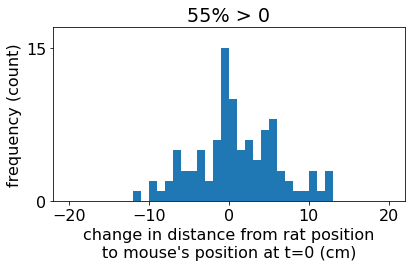

In [8]:
plt.hist(dds, bins=np.linspace(-20, 20, 41))
plt.xlabel('change in distance from rat position\nto mouse\'s position at t=0 (cm)')
plt.ylabel('frequency (count)')
plt.ylim(0, 17)
plt.yticks([0, 15])
plt.title('{}% > 0'.format(int(np.round(np.mean(dds > 0)*100))))
plt.tight_layout()
plt.savefig('./elife_figs/rat_movement_direction_response_1h.svg')

In [8]:
colors = ['r', 'k', 'b']
behavs = ['approach', 'rat movement', 'escape', 'freeze']

In [9]:
[len(ctab[i]) for i in range(4)]

[317, 317, 317, 249]

approach RanksumsResult(statistic=2.4475556345856604, pvalue=0.014382891830358062)
rat movement RanksumsResult(statistic=-3.7014572135349297, pvalue=0.0002143648077140735)
escape RanksumsResult(statistic=-2.1161942563648326, pvalue=0.03432828951892048)
freeze RanksumsResult(statistic=-3.6198667607448143, pvalue=0.0002947547532337942)


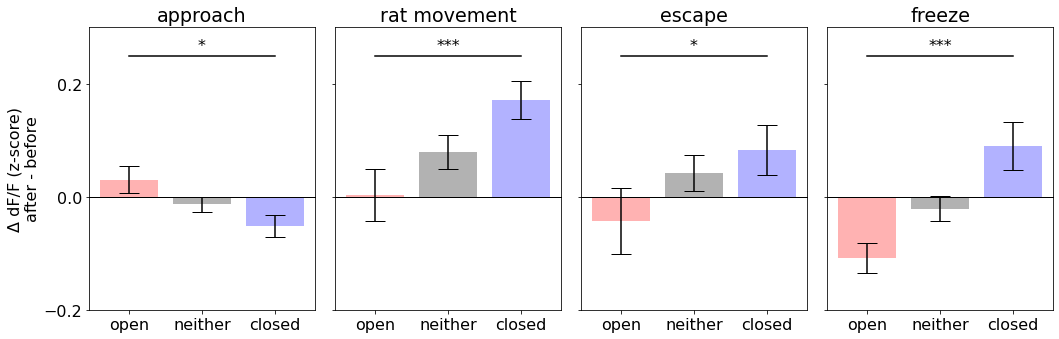

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
stars = ['*', '***', '*', '***']
for i in range(4):
    plt.sca(ax[i])
    diffs = []
    for j, typ in enumerate(['o', 'n', 'c']):
        cta = np.array(ctab[i])
        diff = np.mean(behavtraces[i][cta==typ, 40:59], axis = 1) - np.mean(behavtraces[i][cta==typ, 21:40], axis = 1)
        diffs.append(diff)
        plt.bar(j, np.mean(diff), color=colors[j], alpha=0.3)
        plt.errorbar(j, np.mean(diff), sem(diff), fmt='k_', ms=0, capsize=10)
    print(behavs[i], ranksums(diffs[0], diffs[2]))
    plt.xticks([0, 1, 2], ['open', 'neither', 'closed'])
    plt.title(behavs[i])
    plt.plot(0, 0, 'k_', ms=2000)
    ylim = plt.ylim()
    plt.ylim(ylim)
    plt.plot([0, 2], [0.25]*2, 'k')
    plt.text(1, 0.26, stars[i], ha='center')
plt.sca(ax[0])
plt.ylabel('Δ dF/F (z-score)\nafter - before')
plt.yticks([-0.2, 0, 0.2])
plt.ylim(-0.2, 0.3)
plt.tight_layout()

plt.savefig('./elife_figs/3J.svg')

In [14]:
t = np.arange(-40, 40)/7.5

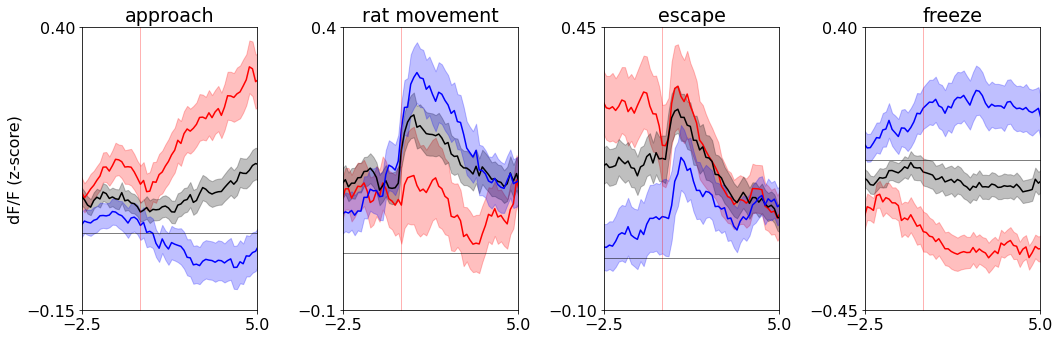

In [15]:
plt.figure(figsize=(15, 5))
ylims = [(-0.15, 0.4), (-0.1, 0.4), (-0.1, 0.45), (-0.45, 0.4)]
yticks = ylims
for i in range(4):
    plt.subplot(1, 4, i+1)
    if i == 0:
        plt.ylabel('dF/F (z-score)')
    for j, typ in enumerate(['o', 'n', 'c']):
        cta = np.array(ctab1[i])
        data = behavtraces1[i][cta==typ]
        tracemu = np.mean(data, axis=0)
        tracesem = sem(data, axis=0)
        plt.fill_between(t, tracemu-tracesem, tracemu+tracesem, alpha=0.25, color=colors[j])
        plt.plot(t, tracemu, color=colors[j])
    
    plt.title(behavs[i])
    plt.xlim(-2.5, 5)
    plt.xticks([-2.5, 5])
    plt.plot(0, 0, 'r|', ms=2000, alpha=0.3)
    plt.plot(0, 0, 'k_', ms=2000, alpha=0.5)
    plt.ylim(*ylims[i])
    plt.yticks(yticks[i])

plt.ylim()
plt.tight_layout()

plt.savefig('./elife_figs/3I.svg')

In [10]:
# rat only
timeBefore = 40
timeAfter = 40

mousenums = ['230', '355', '362', '673', '674', '816', '825']
#
if 'ab' not in globals():
    ab = np.zeros((4, 7, 4)) # behav, mouse, ctype (all, open, neither, closed)
freq = np.zeros((4, 7)) # behav, mouse

behavtraces = []
for b, behavFrame in enumerate(['approachFrameMS', 'stretchFrameMS', 'escapeFrameMS', 'freezeFrameMS']):
    traces = []
    for m, mouse in enumerate(mousenums):
        
        try:
            track2, neur2, behav2 = getdicts(foldnames, mouse, 'rat1')
            rvel = track2['ratVelMS'].flatten()
            calc2 = getcalc(foldnames, mouse, 'rat1')
            calc2 = zscore(calc2)
            
            mpos2 = track2['mouse_positionMS']
            mpos2[:, 0] = minmaxscale(mpos2[:, 0], 0, 70, np.max(track2['rat_positionMS'][:, 0]))
            
            speed = track2['mouseVelMS'].flatten()
            
            
            if behavFrame == 'freezeFrameMS' and behav2['escapeFrameMS'].size > 0:
                fstarts = behav2['freezeFrameMS'][:, 0].astype('int')
                eends = behav2['escapeFrameMS'][:, 1].astype('int')
                f_keeps = np.ones(len(fstarts), dtype='bool')
                for i in range(len(fstarts)):
                    dif = fstarts[i] - eends
                    if np.sum((dif >= 0)*(dif < 75)) > 0:
                        f_keeps[i] = 0
                behav2['freezeFrameMS'] = behav2['freezeFrameMS'][f_keeps]
                print(mouse, 'f', np.size(f_keeps), np.sum(f_keeps==0), np.sum(f_keeps))
            
            if behavFrame == 'escapeFrameMS' and behav2['freezeFrameMS'].size > 0:
                estarts = behav2['escapeFrameMS'][:, 0].astype('int')
                fends = behav2['freezeFrameMS'][:, 1].astype('int')
                e_keeps = np.ones(len(estarts), dtype='bool')
                for i in range(len(estarts)):
                    dif = estarts[i] - fends
                    if np.sum((dif >=0)*(dif < 75)) > 0:
                        e_keeps[i] = 0
                behav2['escapeFrameMS'] = behav2['escapeFrameMS'][e_keeps]
                print(mouse, 'e', np.size(e_keeps), np.sum(e_keeps==0), np.sum(e_keeps))
            
            starttimes = []
            endtimes = []
            for starttime, endtime in zip(behav2[behavFrame][:, 0], behav2[behavFrame][:, 1]):
                if starttime > timeBefore and calc2.shape[0] - starttime > timeAfter:
                    starttimes.append(starttime)
                    endtimes.append(endtime)
                    freq[b, m] += 1
            starttimes = np.array(starttimes)
            endtimes = np.array(endtimes)
            
            if len(starttimes) < 5:
                print(mouse, behavFrame, '<5')
                continue
            ct = np.array(['']*calc2.shape[1])
            mouse_traces = []
            for cell in range(calc2.shape[1]):
                trace = np.zeros((starttimes.size, timeBefore+timeAfter))
                for k, starttime in enumerate(starttimes):
                    endtime = endtimes[k]
                    trace[k] = calc2[starttime-timeBefore:starttime+timeAfter, cell]
                traces.append(np.mean(trace, axis=0))
                mouse_traces.append(np.mean(trace, axis=0))
            mouse_traces = np.array(mouse_traces)
            ab[b, m, 0] = np.mean(np.mean(mouse_traces[:, 40:59]) - np.mean(
                mouse_traces[:, 21:40]))
            
        except:
            print(behavFrame, mouse, 'no instances')
            pass
    traces = np.array(traces)
    behavtraces.append(traces)
behavtraces2 = behavtraces

674 stretchFrameMS <5
355 e 19 0 19
362 e 49 0 49
673 e 10 1 9
674 e 14 0 14
816 e 29 2 27
825 e 16 0 16
freezeFrameMS 230 no instances
355 f 21 7 14
362 f 8 1 7
673 f 3 0 3
673 freezeFrameMS <5
674 f 21 7 14
816 f 15 6 9
825 f 64 21 43


In [11]:
# rat only
timeBefore = 40
timeAfter = 40

rmovetraces = []
for m, mouse in enumerate(mousenums):
    track2, neur2, behav2 = getdicts(foldnames, mouse, 'rat1')
    rvel = track2['ratVelMS'].flatten()
    calc2 = getcalc(foldnames, mouse, 'rat1')
    calc2 = zscore(calc2)
    
    threshold = np.percentile(rvel, 99.5)
    T = rvel.shape[0]
    starttimes = []
    lasttime = 0
    timediff = 40
    for t in range(timeBefore, T - timeAfter):
        if rvel[t] > threshold:
            if t - lasttime > timediff:
                starttimes.append(t)
                freq[1, m] += 1
            lasttime = t
    starttimes = np.array(starttimes)
    
    if len(starttimes) < 5:
        print('skipping {}, {}'.format(mouse))
        continue
    mouse_traces = []
    for cell in range(calc2.shape[1]):
        trace = np.zeros((starttimes.size, timeBefore+timeAfter))
        for k, starttime in enumerate(starttimes):
            trace[k] = calc2[starttime-timeBefore:starttime+timeAfter, cell]
        mouse_traces.append(np.mean(trace, axis=0))
        rmovetraces.append(np.mean(trace, axis=0))
    mouse_traces = np.array(mouse_traces)
    ab[1, m, 0] = np.mean(np.mean(mouse_traces[:, 40:59]) - np.mean(
        mouse_traces[:, 21:40]))
rmovetraces = np.array(rmovetraces)

In [12]:
behavtraces[1] = rmovetraces

In [13]:
[behavtraces[i].shape[0] for i in range(4)]

[713, 713, 713, 546]

In [14]:
freq

array([[ 46.,  39., 104.,  15.,  18.,  34.,  19.],
       [ 49.,  25.,  29.,  24.,  17.,  55.,  26.],
       [ 30.,  19.,  49.,   9.,  14.,  27.,  16.],
       [  0.,  14.,   7.,   3.,  14.,   9.,  43.]])

In [18]:
import scipy.stats

In [19]:
def pearsonr_ci(x,y,alpha=0.05):
    # calculate Pearson correlation along with the confidence interval using Fisher transformation
    # alpha: confidence level
    r, p = scipy.stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = scipy.stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

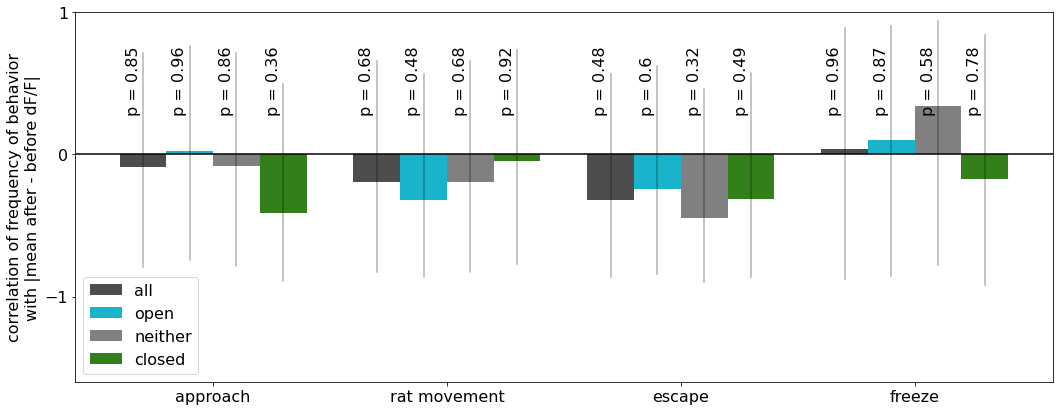

In [55]:
plt.figure(figsize=(15, 6))
colors = [(0.3, 0.3, 0.3), (0.1, 0.7, 0.8), (0.5, 0.5, 0.5), (0.2, 0.5, 0.1)]
for b in range(4):
    for c in range(4):
        nz = (ab[b, :, c] != 0)
        #r, p = pearsonr(freq[b, nz], np.abs(ab[b, nz, c]))
        r, p, lo, hi = pearsonr_ci(freq[b, nz], np.abs(ab[b, nz, c]), alpha=0.05)
        
        plt.bar(b+0.2*c, r, width=0.2, color=colors[c])
        plt.plot([b+0.2*c]*2, [lo, hi], 'k', alpha=0.3, label='_nolegend_')
        #plt.errorbar(b+0.2*c, r, 1/np.sqrt(n-3), fmt='k', label='_nolegend_')
        plt.text(b+0.2*c - 0.01, 0.3, 'p = ' + str(np.round(p, 2)), rotation=90, ha='right')
#plt.ylim(-0.7, 0.7)
plt.ylim(-1.6, 1)
plt.yticks([-1, 0, 1])
plt.xlim(plt.xlim())
plt.plot(plt.xlim(), [0]*2, 'k', label='_nolegend_')
plt.ylabel('correlation of frequency of behavior\nwith |mean after - before dF/F|')
plt.xticks(np.arange(4)+0.3, ['approach', 'rat movement', 'escape', 'freeze'])
plt.legend(['all', 'open', 'neither', 'closed'], loc='lower left')
plt.tight_layout()
plt.savefig('./elife_figs/correlate_frequency_with_pop_response.svg')

approach Ttest_1sampResult(statistic=-2.6514724495691726, pvalue=0.008192436266849018)
rat movement Ttest_1sampResult(statistic=7.874466249566844, pvalue=1.2782871213596489e-14)
escape Ttest_1sampResult(statistic=3.2857109265379205, pvalue=0.0010671052571075504)
freeze Ttest_1sampResult(statistic=0.3978236070091007, pvalue=0.6909159908929734)


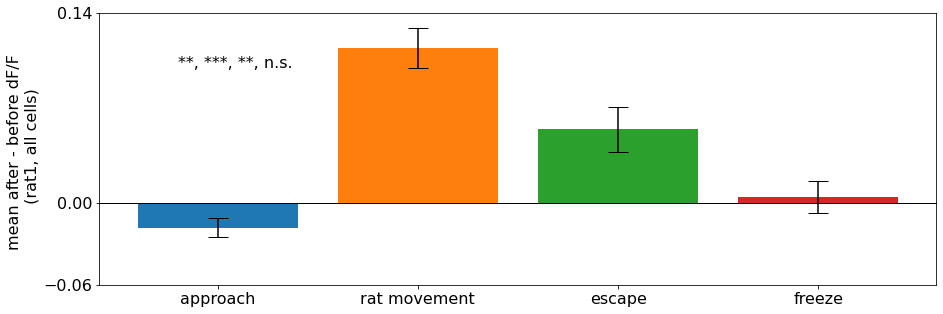

In [20]:
plt.figure(figsize=(15, 5))
for i in range(4):
    diff = np.mean(behavtraces[i][:, 40:59], axis = 1) - np.mean(behavtraces[i][:, 21:40], axis = 1)
    plt.bar(i, np.mean(diff))
    plt.errorbar(i, np.mean(diff), sem(diff), fmt='k_', ms=0, capsize=10)
    print(behavs[i], ttest_1samp(diff, 0))
plt.plot(0, 0, 'k_', ms=2000)
plt.xticks(np.arange(4), behavs)
plt.ylabel('mean after - before dF/F \n (rat1, all cells)')
plt.yticks([-0.06, 0, 0.14])
plt.ylim(-0.06, 0.14)
plt.text(-0.2, 0.1, '**, ***, **, n.s.')

plt.savefig('./elife_figs/3D.svg')

In [21]:
t = np.arange(-40, 40)/7.5

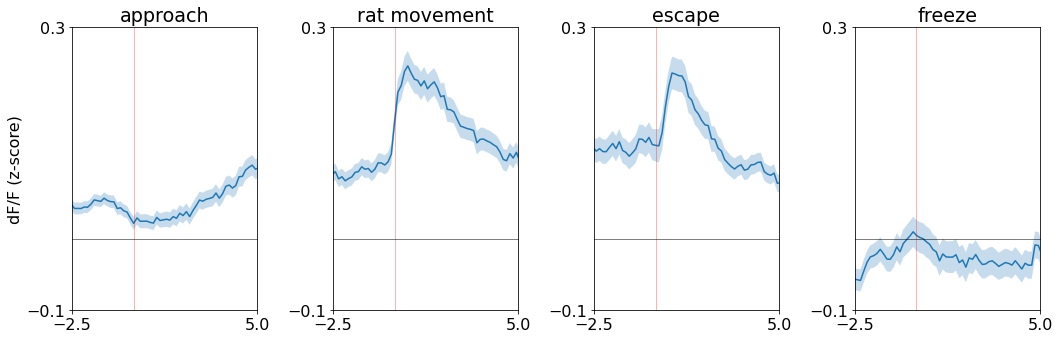

In [22]:
plt.figure(figsize=(15, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    if i == 0:
        plt.ylabel('dF/F (z-score)')
    tracemu = np.mean(behavtraces[i], axis=0)
    tracesem = sem(behavtraces[i], axis=0)
    plt.fill_between(t, tracemu-tracesem, tracemu+tracesem, alpha=0.25)
    plt.plot(t, tracemu)
    
    plt.title(behavs[i])
    plt.xlim(-2.5, 5)
    plt.xticks([-2.5, 5])
    plt.plot(0, 0, 'r|', ms=2000, alpha=0.3)
    plt.plot(0, 0, 'k_', ms=2000, alpha=0.5)
    plt.ylim(-0.1, 0.3)
    plt.yticks([-0.1, 0.3])

plt.ylim()
plt.tight_layout()

plt.savefig('./elife_figs/3E.svg')